## **Subgroup B Question 1**

The demand forecasting model is created using the following features


*   is_raining : whether the weather forecast indicates the presence of thunder or rain
*   mean_temperature : the average of the low and high temperature within the time
*   is_weekend : whether the day falls on a weekend
*   is_special_event : whether the day coincides with a special event implemented by Universal Studios Singapore eg. themed celebrations or special pop up events
*   is_holiday : whether the day coincides with a school or public holiday
*   international_tourists : the volume of international tourists entering Singapore for that particular day









In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score

In [ ]:
# Load the combined dataset
combined_data = pd.read_csv('../../data/processed/uss_waittime_and_weather.csv')
combined_data['datetime'] = pd.to_datetime(combined_data['datetime'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
# Add weekends
combined_data['is_weekend'] = combined_data['datetime'].apply(lambda x: 1 if x.weekday() >= 5 else 0)

# Add holidays
holiday_data = pd.read_excel('../../data/processed/uss_sg_holidays.xls')
holiday_data['date'] = pd.to_datetime(holiday_data['date'], format='%m/%d/%Y')
combined_data['date'] = combined_data['datetime'].dt.date

# Create a set of holiday dates for fast lookup
event_dates = set(holiday_data['date'].dt.date)

combined_data['is_holiday'] = combined_data['date'].apply(lambda x: 1 if x in event_dates else 0)
combined_data = combined_data.drop(columns=['date'])

print(combined_data['is_holiday'].value_counts())

is_holiday
0    6580
1    1420
Name: count, dtype: int64


In [ ]:
# Add special events
special_events_data = pd.read_excel('../../data/processed/uss_special_events.xlsx')

special_events_data['date'] = pd.to_datetime(special_events_data['date'], format='%m/%d/%Y')
special_event_dates = set(special_events_data['date'].dt.date)
combined_data['date'] = combined_data['datetime'].dt.date

combined_data['is_special_event'] = combined_data['date'].apply(lambda x: 1 if x in special_event_dates else 0)


combined_data = combined_data.drop(columns=['date'])

print(combined_data['is_special_event'].value_counts())

is_special_event
0    4115
1    3885
Name: count, dtype: int64


In [ ]:
# Strip extra whitespace and load the tourist data
tourist_data = pd.read_excel('../../data/processed/uss_international_tourist_arrival.xlsx')
tourist_data['Data Series'] = tourist_data['Data Series'].str.strip()

# Extract year and month from the "Data Series" column
tourist_data['year'] = tourist_data['Data Series'].str.split().str[0].astype(int)
tourist_data['month'] = pd.to_datetime(tourist_data['Data Series'], errors='coerce', format='%Y %b').dt.month

# Select and rename relevant columns
tourist_data = tourist_data[['year', 'month', 'Total International Visitor Arrivals By Inbound Tourism Markets']]
tourist_data.columns = ['year', 'month', 'international_tourists']

# Create a dictionary for mapping year and month to international tourists
tourist_dict = tourist_data.set_index(['year', 'month'])['international_tourists'].to_dict()

# Add year and month columns to merged_data for mapping
combined_data['year'] = combined_data['datetime'].dt.year
combined_data['month'] = combined_data['datetime'].dt.month

# Map the tourist data to merged_data based on year and month
combined_data['international_tourists'] = combined_data.apply(lambda row: tourist_dict.get((row['year'], row['month']), 0), axis=1)

# Drop the temporary year and month columns
combined_data = combined_data.drop(columns=['year', 'month'])

# Verify the result
print(combined_data)


                 datetime  average_waittime  mean temperature (°C)  \
0     2023-01-02 11:00:00          7.916667                   28.5   
1     2023-01-02 11:30:00         27.272727                   28.5   
2     2023-01-02 12:00:00         37.232143                   28.5   
3     2023-01-02 12:30:00         47.822581                   28.5   
4     2023-01-02 13:00:00         45.135135                   28.5   
...                   ...               ...                    ...   
22567 2024-06-30 16:30:00         23.154762                   27.5   
22568 2024-06-30 17:00:00         22.440476                   27.5   
22569 2024-06-30 17:30:00         19.761905                   27.5   
22570 2024-06-30 18:00:00         14.464286                   29.5   
22571 2024-06-30 18:30:00         14.523810                   29.5   

       is raining  is_special_event  international_tourists  is_weekend  \
0               0                 0                  931814           0   
1        

In [ ]:
# Display the rows where 'average_waittime' is NaN
nan_rows = combined_data[combined_data['average_waittime'].isnull()]
# Drop rows where 'average_waittime' is NaN
combined_data = combined_data.dropna(subset=['average_waittime'])
# Drop Forecast Column
combined_data = combined_data.drop(columns=['forecast'])

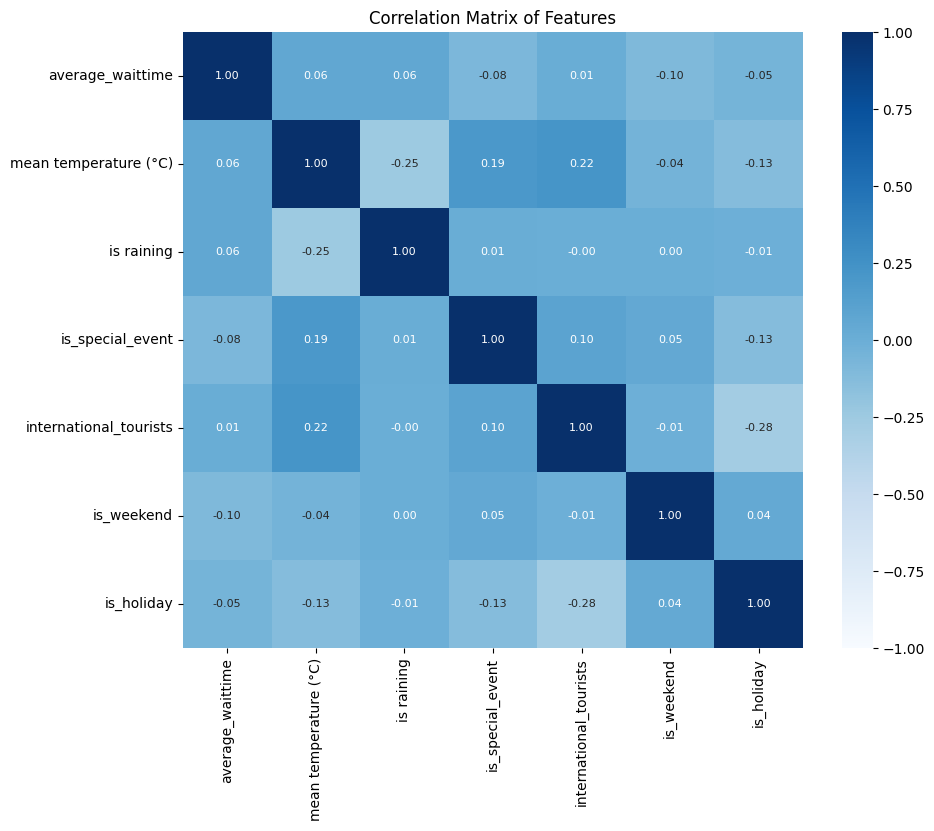

In [ ]:
# Drop the datetime column, as it's not relevant for correlation calculations
features_for_correlation = combined_data.drop(columns=['datetime'])

# Create a correlation matrix for all features
feature_matrix = features_for_correlation.corr(method="spearman").round(2)

plt.figure(figsize=(10, 8))
sns.heatmap(feature_matrix, cmap="Blues", vmin=-1, vmax=1, annot=True, fmt=".2f", annot_kws={"size":8})
plt.title("Correlation Matrix of Features")
plt.show()

In [ ]:
# prompt: get descriptive stats of combined_data

combined_data.describe(include='all')

,datetime,average_waittime,mean temperature (°C),is raining,is_special_event,international_tourists,is_weekend,is_holiday
count,8000,8000.000000,8000.000000,8000.000000,8000.000000,8.000000e+03,8000.000000,8000.000000
mean,2023-10-31 10:50:38.849999872,24.271443,28.898563,0.397125,0.485625,1.233154e+06,0.304500,0.177500
min,2023-01-02 11:00:00,2.000000,24.000000,0.000000,0.000000,9.318140e+05,0.000000,0.000000
25%,2023-06-29 12:22:30,14.634146,28.500000,0.000000,0.000000,1.125964e+06,0.000000,0.000000
50%,2023-11-11 15:45:00,22.538462,29.000000,0.000000,0.000000,1.250291e+06,0.000000,0.000000
75%,2024-03-15 11:07:30,31.837109,29.500000,1.000000,1.000000,1.417807e+06,1.000000,0.000000
max,2024-06-30 18:30:00,70.367647,31.000000,1.000000,1.000000,1.464865e+06,1.000000,1.000000
std,NaN,12.140866,0.937504,0.489333,0.499825,1.544013e+05,0.460224,0.382115


In [ ]:
# Split data into train-validation-test: 70-15-15

X = combined_data.drop(['average_waittime', 'datetime'], axis=1)
y = combined_data['average_waittime']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)


print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (5600, 6), (5600,)
Validation set: (1200, 6), (1200,)
Test set: (1200, 6), (1200,)


We use Mean Absolute Error (MAE) as our loss function as it represents the magnitude of the error in a more intuitive, understandable way for stakeholders. Furthermore, the implications for large errors are less severe than when dealing with target variables associated with cost. In such cases, using RMSE would be more suitable.

In [ ]:
# Tune the hyperparameters of the random forest regressor

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error',  # Optimize based on neg MAE
                           cv=5,                              # 5-fold cross-validation
                           verbose=1,                         # To get detailed output of progress
                           n_jobs=-1)                         # Utilize all processors for faster grid search


grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Lowest MAE found: ", -grid_search.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Lowest MAE found:  7.2532324997143265


In [ ]:
# Use the best model from the grid search to predict on the validation set
best_model = grid_search.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val)

# Calculate MAE and R² on the validation set
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

# Output the results
print(f"Validation MAE: {mae_val}")
print(f"Validation R²: {r2_val}")

Validation MAE: 6.87936182852647
Validation R²: 0.48066839204903067


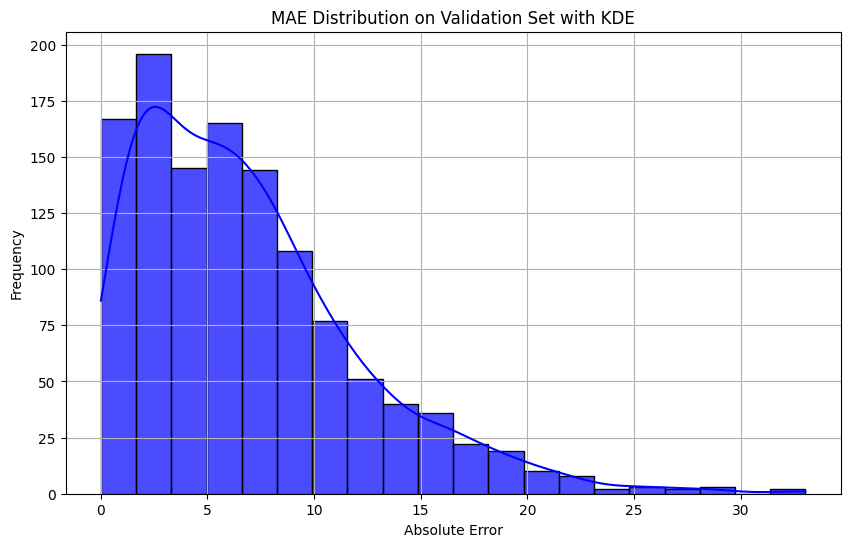

In [ ]:
# Calculate the absolute errors for the validation set
abs_errors = np.abs(y_val - y_val_pred)

# Plot the distribution of absolute errors (MAE) on the validation set
plt.figure(figsize=(10, 6))
sns.histplot(abs_errors, bins=20, kde=True, color='blue', alpha=0.7)  # Adding KDE for smooth curve
plt.title('MAE Distribution on Validation Set with KDE')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

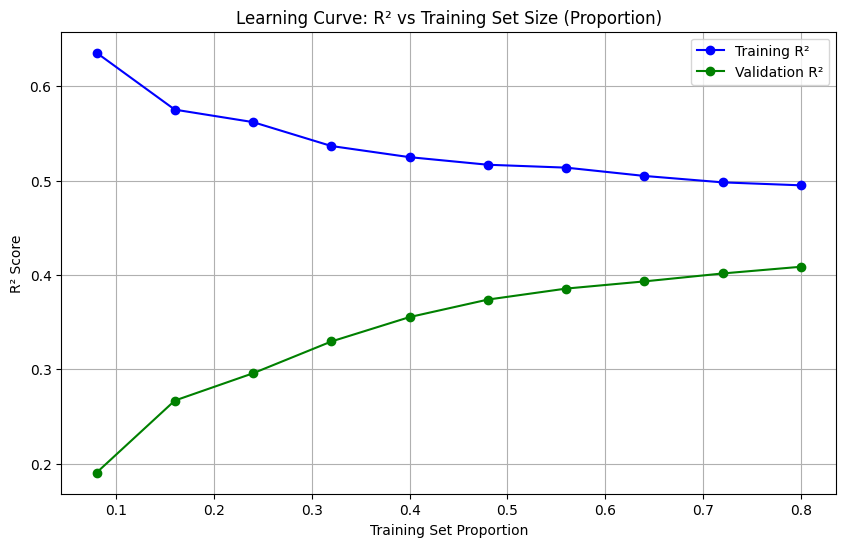

In [ ]:
# Calculate learning curve (same as before but use proportion for the x-axis)
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # Proportion from 10% to 100%
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Calculate mean and standard deviation for train and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes / len(X_train), train_scores_mean, label='Training R²', color='blue', marker='o')
plt.plot(train_sizes / len(X_train), val_scores_mean, label='Validation R²', color='green', marker='o')

plt.title('Learning Curve: R² vs Training Set Size (Proportion)')
plt.xlabel('Training Set Proportion')
plt.ylabel('R² Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
# Predict on the train, validation, and test sets
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# Calculate MAE for train, validation, and test sets
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Calculate R² for train, validation, and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results
print(f"Training MAE: {mae_train}")
print(f"Validation MAE: {mae_val}")
print(f"Test MAE: {mae_test}")

print(f"Training R²: {r2_train}")
print(f"Validation R²: {r2_val}")
print(f"Test R²: {r2_test}")

Training MAE: 6.702035197725597
Validation MAE: 6.87936182852647
Test MAE: 6.9402282159890545
Training R²: 0.48801850651612366
Validation R²: 0.48066839204903067
Test R²: 0.4501535621944762


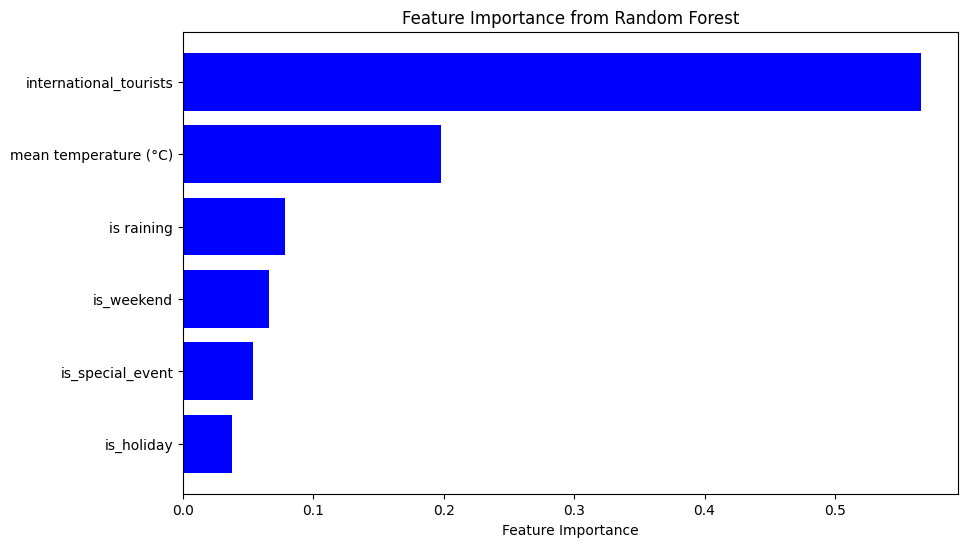

In [ ]:
# Get the feature importance from the best model
importances = best_model.feature_importances_

# Create a DataFrame for better readability
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

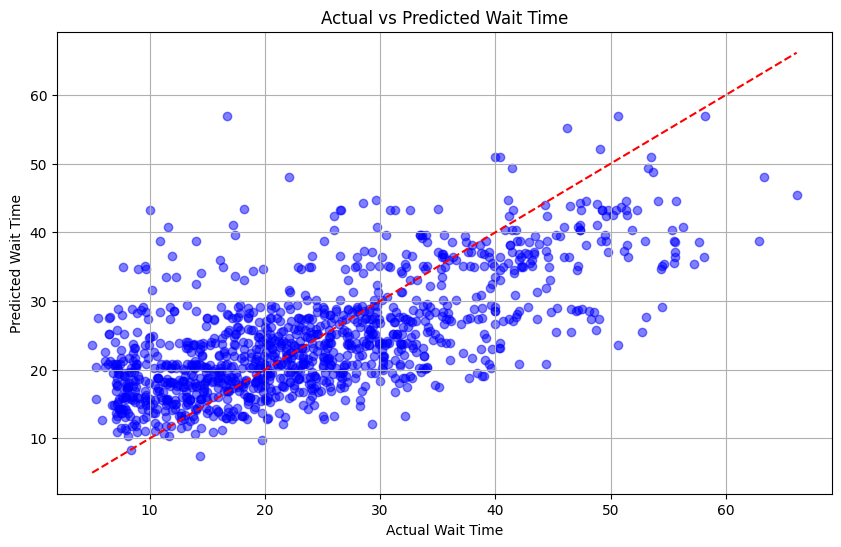

In [ ]:
# Plot actual vs predicted for the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Straight line for reference
plt.xlabel('Actual Wait Time')
plt.ylabel('Predicted Wait Time')
plt.title('Actual vs Predicted Wait Time')
plt.grid(True)
plt.show()

### Conclusion

From the data above,

*   We have achieved a test R^2 of 0.45
*   The most influential feature is the number of international tourists arrivals to Singapore

To illustrate this, we have implemented a RandomForestRegressor model below

In [ ]:
import pickle
from sklearn.ensemble import RandomForestRegressor

with open("/src/model/rf_model.pkl", "wb") as file:
    pickle.dump(best_model, file)

## **Subgroup B Optional Question 1**

The demand forecasting model is enhanced using the following features derived from external factors


*   sentiment : the average sentiment rating from online reviews




In [ ]:
sentiment_data = pd.read_csv('../../data/processed/tripadvisor_sentiment_analysis.csv')
sentiment_data['reviewDate'] = pd.to_datetime(sentiment_data['reviewDate'], dayfirst=True, errors='coerce')

<ipython-input-45-eb18dc4d113f>:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  sentiment_data['reviewDate'] = pd.to_datetime(sentiment_data['reviewDate'], dayfirst=True, errors='coerce')


In [ ]:
# Aggregate sentiment by day (summing sentiment values for each day)
sentiment_aggregated = sentiment_data.groupby(sentiment_data['reviewDate'].dt.date)['computed_sentiment'].sum().reset_index()

# Rename 'reviewDate' to 'date' to make merging easier
sentiment_aggregated = sentiment_aggregated.rename(columns={'reviewDate': 'date'})

# Convert 'date' in sentiment_aggregated to datetime format for merging
sentiment_aggregated['date'] = pd.to_datetime(sentiment_aggregated['date'])

# Extract the 'date' part from the 'datetime' column in combined_data
combined_data['date'] = combined_data['datetime'].dt.date

# Convert the 'date' column in combined_data to datetime format
combined_data['date'] = pd.to_datetime(combined_data['date'])

# Merge the datasets on the 'date' column, assigning the daily sentiment to each 30-minute interval
merged_data = pd.merge(combined_data, sentiment_aggregated, on='date', how='left')

# Fill any missing sentiment values with 0 (in case a date in combined data has no reviews)
merged_data['computed_sentiment'] = merged_data['computed_sentiment'].fillna(0)

# Drop the 'date' column if no longer needed
merged_data = merged_data.drop(columns=['date'])

merged_data

,datetime,average_waittime,mean temperature (°C),is raining,is_special_event,international_tourists,is_weekend,is_holiday,computed_sentiment
0,2023-01-02 11:00:00,7.916667,28.5,0,0,931814,0,1,0.0
1,2023-01-02 11:30:00,27.272727,28.5,0,0,931814,0,1,0.0
2,2023-01-02 12:00:00,37.232143,28.5,0,0,931814,0,1,0.0
3,2023-01-02 12:30:00,47.822581,28.5,0,0,931814,0,1,0.0
4,2023-01-02 13:00:00,45.135135,28.5,0,0,931814,0,1,0.0
...,...,...,...,...,...,...,...,...,...
7995,2024-06-30 16:30:00,23.154762,27.5,0,1,1250291,1,0,1.0
7996,2024-06-30 17:00:00,22.440476,27.5,0,1,1250291,1,0,1.0
7997,2024-06-30 17:30:00,19.761905,27.5,0,1,1250291,1,0,1.0
7998,2024-06-30 18:00:00,14.464286,29.5,0,1,1250291,1,0,1.0


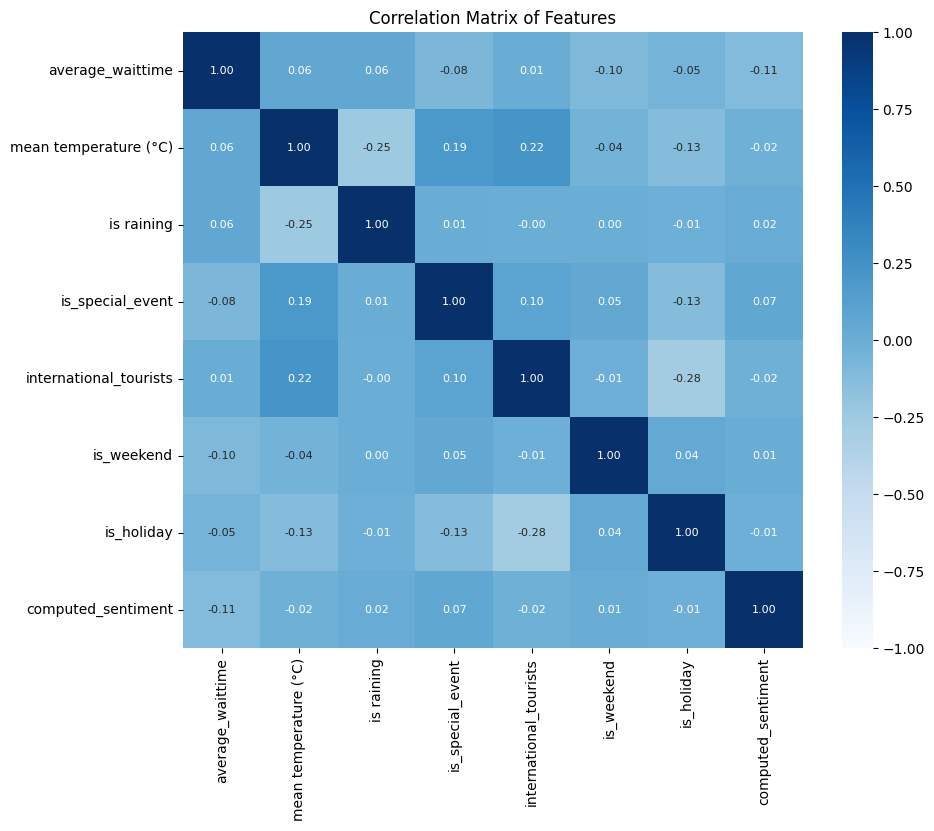

In [ ]:
# Drop the datetime column, as it's not relevant for correlation calculations
features_for_correlation = merged_data.drop(columns=['datetime'])

# Create a correlation matrix for all features
feature_matrix = features_for_correlation.corr(method="spearman").round(2)

plt.figure(figsize=(10, 8))
sns.heatmap(feature_matrix, cmap="Blues", vmin=-1, vmax=1, annot=True, fmt=".2f", annot_kws={"size":8})
plt.title("Correlation Matrix of Features")
plt.show()

Training set: (5600, 7), (5600,)
Validation set: (1200, 7), (1200,)
Test set: (1200, 7), (1200,)
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Lowest MAE found:  6.896126491966316
Validation MAE: 6.435736649330108
Validation R²: 0.5235188041900758


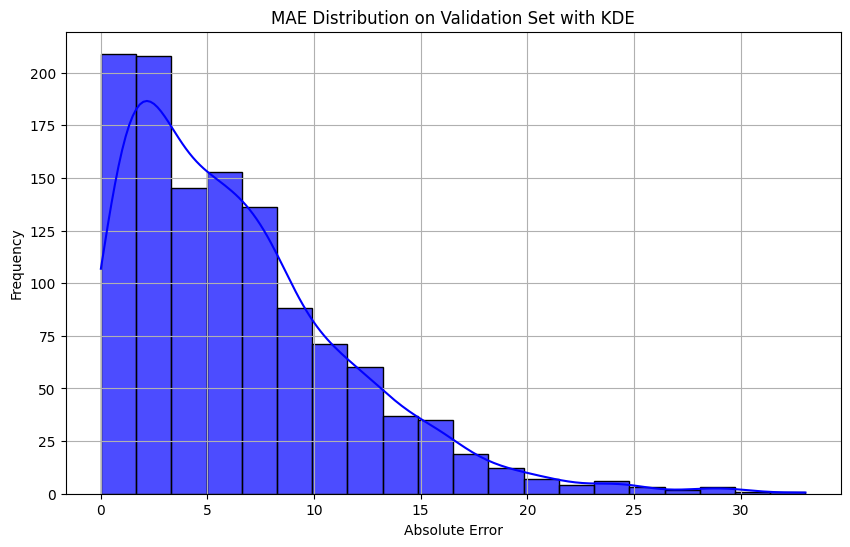

In [ ]:
# Split data into train-validation-test: 70-15-15

X = merged_data.drop(['average_waittime', 'datetime'], axis=1)
y = merged_data['average_waittime']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)


print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Tune the hyperparameters of the random forest regressor

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error',  # Optimize based on neg MAE
                           cv=5,                              # 5-fold cross-validation
                           verbose=1,                         # To get detailed output of progress
                           n_jobs=-1)                         # Utilize all processors for faster grid search


grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Lowest MAE found: ", -grid_search.best_score_)

# Use the best model from the grid search to predict on the validation set
best_model = grid_search.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val)

# Calculate MAE and R² on the validation set
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

# Output the results
print(f"Validation MAE: {mae_val}")
print(f"Validation R²: {r2_val}")

# Calculate the absolute errors for the validation set
abs_errors = np.abs(y_val - y_val_pred)

# Plot the distribution of absolute errors (MAE) on the validation set
plt.figure(figsize=(10, 6))
sns.histplot(abs_errors, bins=20, kde=True, color='blue', alpha=0.7)  # Adding KDE for smooth curve
plt.title('MAE Distribution on Validation Set with KDE')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


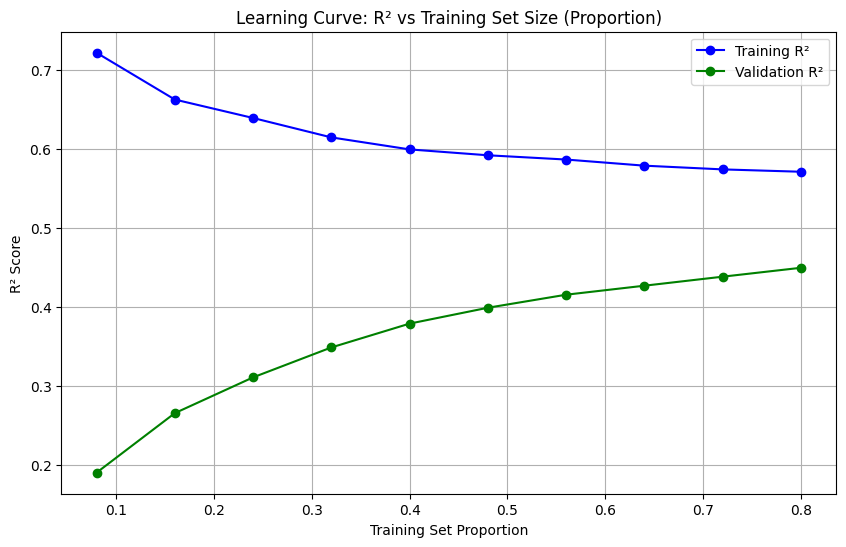

Training MAE: 6.110014288139326
Validation MAE: 6.435736649330108
Test MAE: 6.767520804441582
Training R²: 0.562439310776752
Validation R²: 0.5235188041900758
Test R²: 0.4825904773275217


In [ ]:
# Calculate learning curve (same as before but use proportion for the x-axis)
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # Proportion from 10% to 100%
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Calculate mean and standard deviation for train and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes / len(X_train), train_scores_mean, label='Training R²', color='blue', marker='o')
plt.plot(train_sizes / len(X_train), val_scores_mean, label='Validation R²', color='green', marker='o')

plt.title('Learning Curve: R² vs Training Set Size (Proportion)')
plt.xlabel('Training Set Proportion')
plt.ylabel('R² Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Predict on the train, validation, and test sets
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# Calculate MAE for train, validation, and test sets
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Calculate R² for train, validation, and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results
print(f"Training MAE: {mae_train}")
print(f"Validation MAE: {mae_val}")
print(f"Test MAE: {mae_test}")

print(f"Training R²: {r2_train}")
print(f"Validation R²: {r2_val}")
print(f"Test R²: {r2_test}")

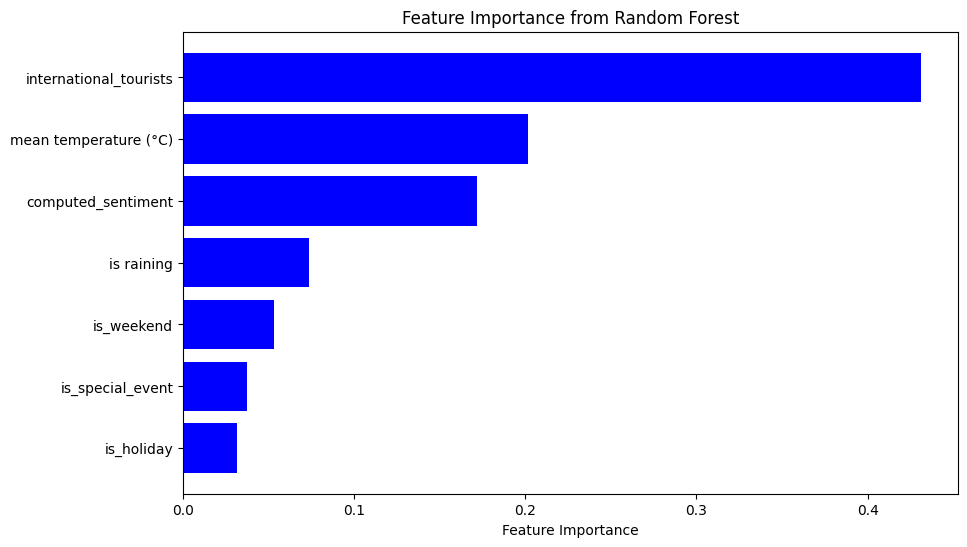

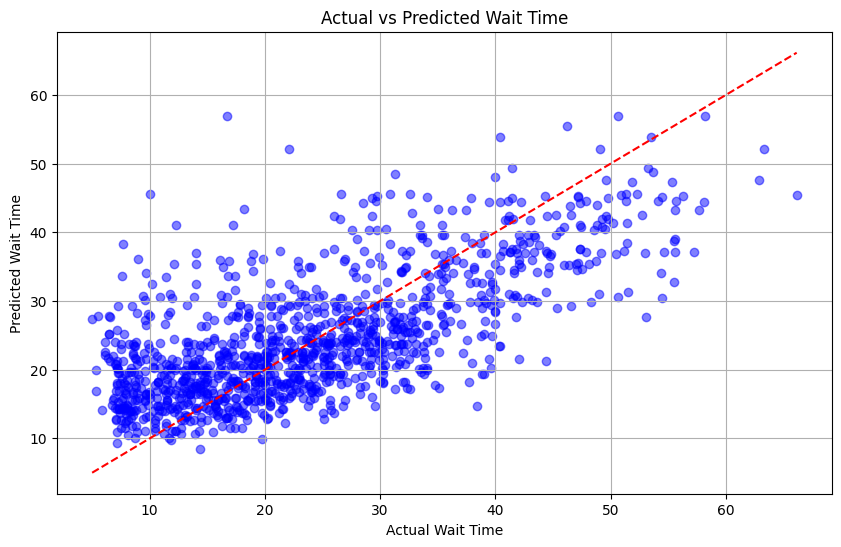

In [ ]:
# Get the feature importance from the best model
importances = best_model.feature_importances_

# Create a DataFrame for better readability
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

# Plot actual vs predicted for the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Straight line for reference
plt.xlabel('Actual Wait Time')
plt.ylabel('Predicted Wait Time')
plt.title('Actual vs Predicted Wait Time')
plt.grid(True)
plt.show()